# Тестовое задание

Импорт библиотек

Очистка данных

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
data = pd.read_csv('TS17_.csv', sep = ';', encoding = 'cp1251', index_col = 'Time', parse_dates = ['Time'],
                  dayfirst = True)

Посмотрим на данные

In [3]:
data.head()

,T,S
Time,,
2017-01-01 00:00:00,324.5339355,11.45427036
2017-01-01 00:01:00,324.5525513,11.45943356
2017-01-01 00:02:00,324.571167,11.4645977
2017-01-01 00:03:00,324.5898132,11.46976089
2017-01-01 00:04:00,324.5997314,11.47492409


#### Начинаем чистить данные

Under Range - на 0 (вытекает из простой логики, так как перед under range данные уходят на нулевой уровень)

Остальные значения пока заменим на NaN, впоследствии выполним интерполяцию

Так как в данных встречается мусор в виде hexadecimal numbers, то при преобразовании рядов к типу float выставляем параметр errors = 'coerce', который переводит ошибки парсинга ряда в NaN, а все прочее мы заменили на предыдущем шаге 

In [4]:
data.replace('Under Range', 0, inplace = True)
data.replace('Bad', np.nan, inplace = True)
data.replace('Error', np.nan, inplace = True)
data.replace('Failed', np.nan, inplace = True)

In [5]:
S = pd.to_numeric(data['S'], errors = 'coerce', downcast = 'float')
T = pd.to_numeric(data['T'], errors = 'coerce', downcast = 'float')

## Задание 1

Визуализируем ряды

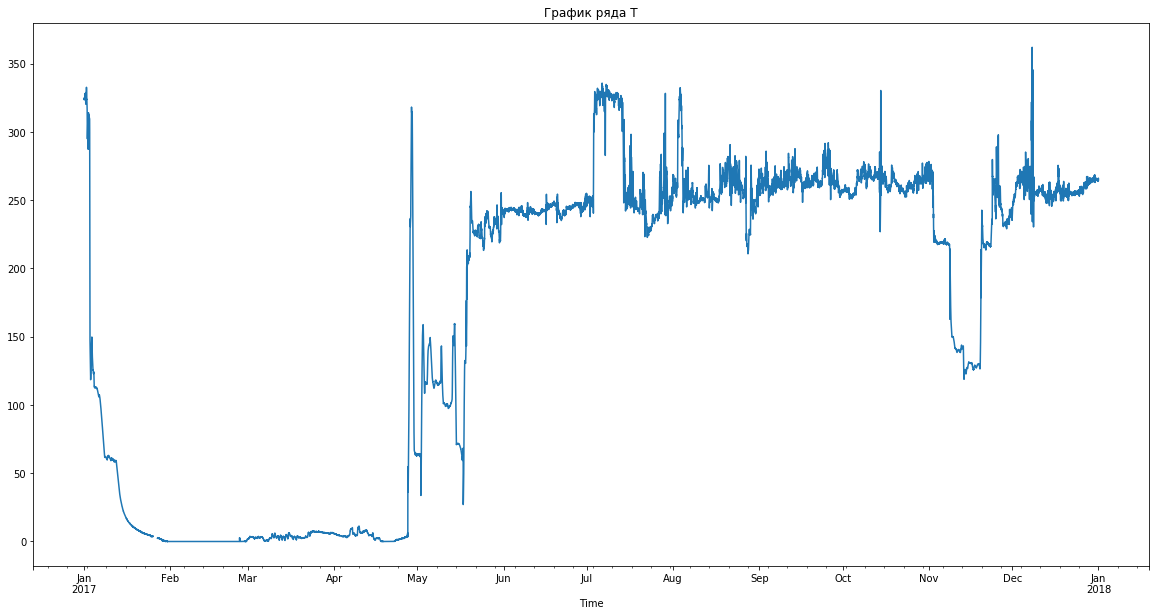

In [6]:
plt.figure(figsize = (20,10))
plt.title('График ряда T')
T.plot()

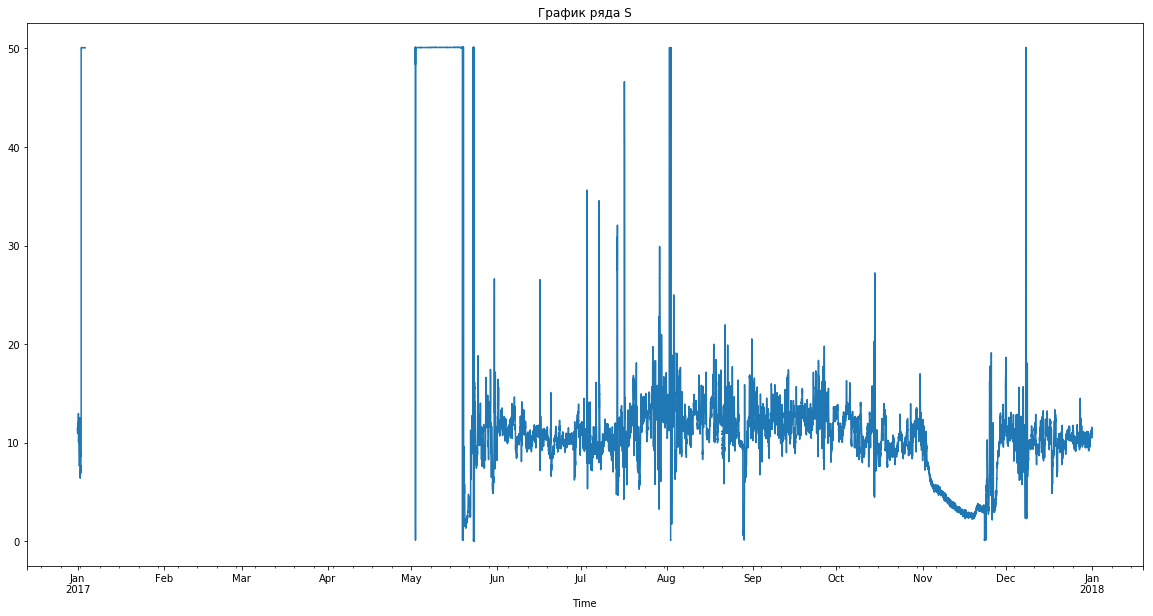

In [7]:
plt.figure(figsize = (20,10))
plt.title('График ряда S')
S.plot()

По исходным данным понятно, что часть ряда нужно отрезать, так как очень много пропусков в данных и до определенного момента ряд ведет себя крайне нестабильно. Ориентировочная дата, когда нужно отрезать - примерно в районе 20 мая. Посмотрим повнимательнее.

In [8]:
S_may = S[(S.index >= '2017-05-20 00:00:00') & (S.index < '2017-06-01 00:00:00')]

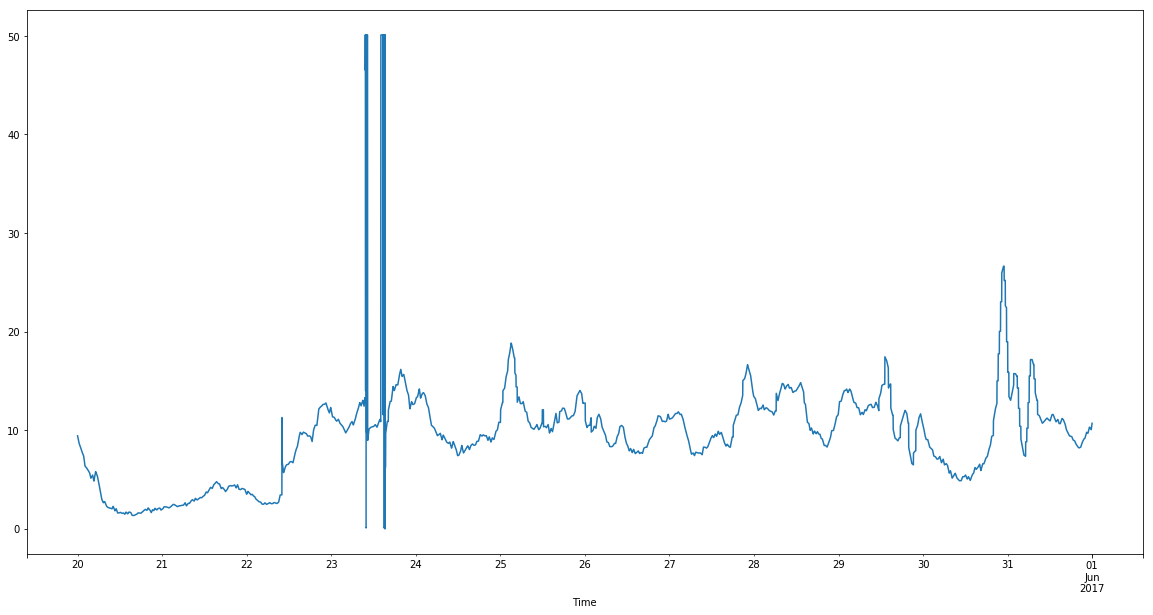

In [9]:
plt.figure(figsize = (20, 10))
S_may.plot()

Отрежем ряд и начнем анализ с 24 мая

In [10]:
S = S[S.index >= '2017-05-24 00:00:00']
T = T[T.index >= '2017-05-24 00:00:00']

Визуализация нынешнего ряда S

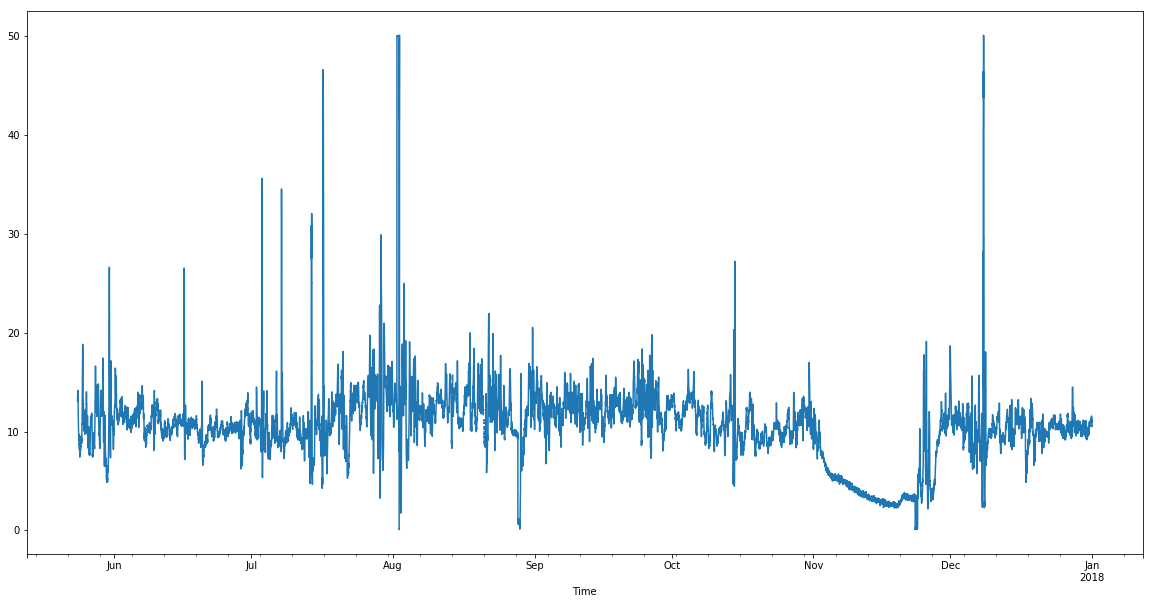

In [11]:
S.plot(figsize = (20, 10))

Визуализация нынешнего ряда T

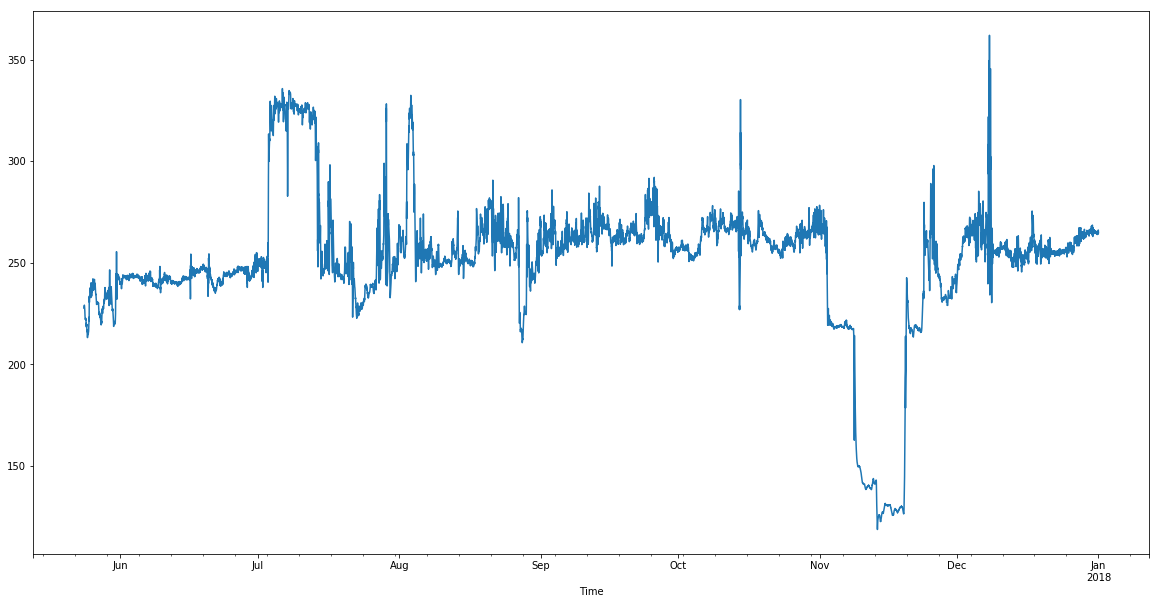

In [12]:
T.plot(figsize = (20, 10))

Интересно посмотреть, как T изменяется в процентах с течением времени. Выглядит стационарно.

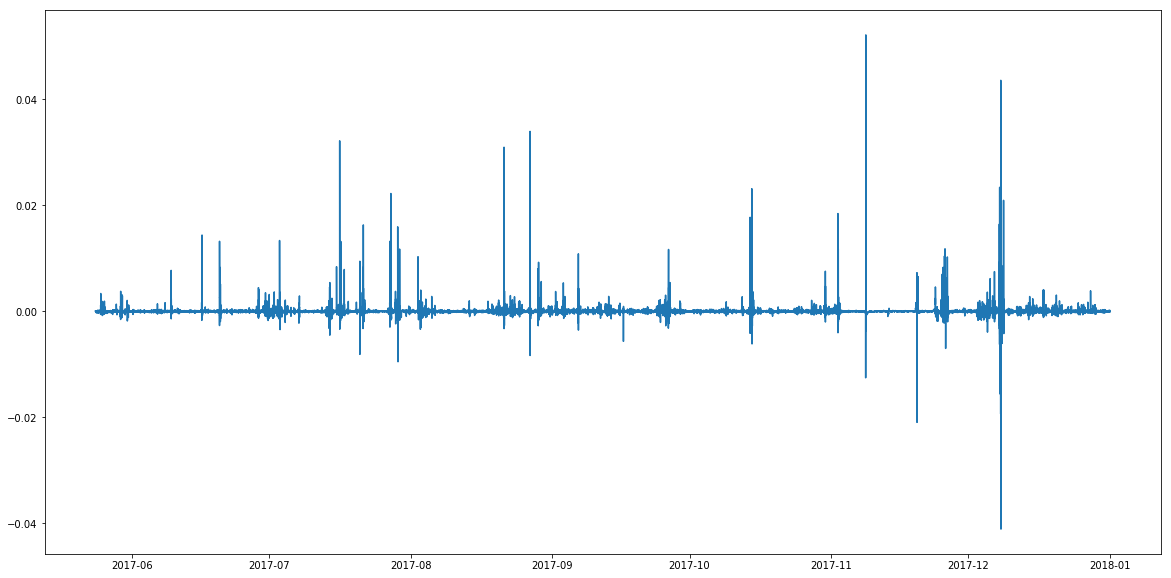

In [13]:
plt.figure(figsize = (20, 10))
plt.plot(T.pct_change())

#### Оценка рядов

Тесты на стационарность для обоих рядов, среднее, дисперсия, попробовать выделить тренд

In [15]:
print('Кол-во пропущенных значений в ряде S: ', S.isna().sum())
print('Кол-во пропущенных значений в ряде T: ', T.isna().sum())

Кол-во пропущенных значений в ряде S:  468
Кол-во пропущенных значений в ряде T:  61


Проведем дополненный тест Дики-Фуллера на стационарность рядов, но перед этим нужно интерполировать пропущенные значения. Так как наши временные ряды содержат большое кол-во значений, необходимо сузить поиск пропущенных значений до места, где они идут подряд. Таким образом получится понять, какой способ интерполяции подойдет лучше всего для данных рядов

In [16]:
from statsmodels.tsa.stattools import adfuller  

In [17]:
S_nans = S[S.isna()]
S_nans.iloc[70:90]

Time
2017-07-30 15:08:00   NaN
2017-08-02 09:11:00   NaN
2017-08-02 09:12:00   NaN
2017-08-02 09:13:00   NaN
2017-08-02 09:14:00   NaN
2017-08-02 09:15:00   NaN
2017-08-02 09:16:00   NaN
2017-08-02 09:17:00   NaN
2017-08-02 09:18:00   NaN
2017-08-02 09:19:00   NaN
2017-08-02 09:20:00   NaN
2017-08-02 09:21:00   NaN
2017-08-02 09:22:00   NaN
2017-08-02 09:23:00   NaN
2017-08-02 09:24:00   NaN
2017-08-02 09:25:00   NaN
2017-08-02 09:26:00   NaN
2017-08-02 09:27:00   NaN
2017-08-02 09:28:00   NaN
2017-08-02 09:29:00   NaN
Name: S, dtype: float32

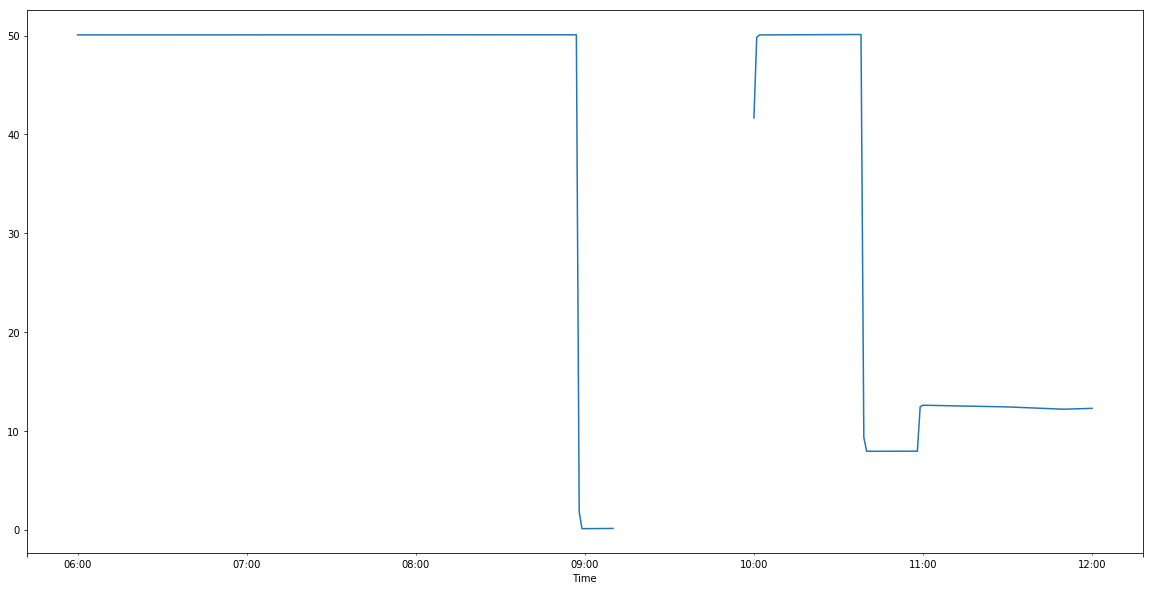

In [18]:
S_for_interpolate = S[(S.index >= '2017-08-02 06:00:00') & (S.index <= '2017-08-02 12:00:00')]
S_for_interpolate.plot(figsize = (20, 10))

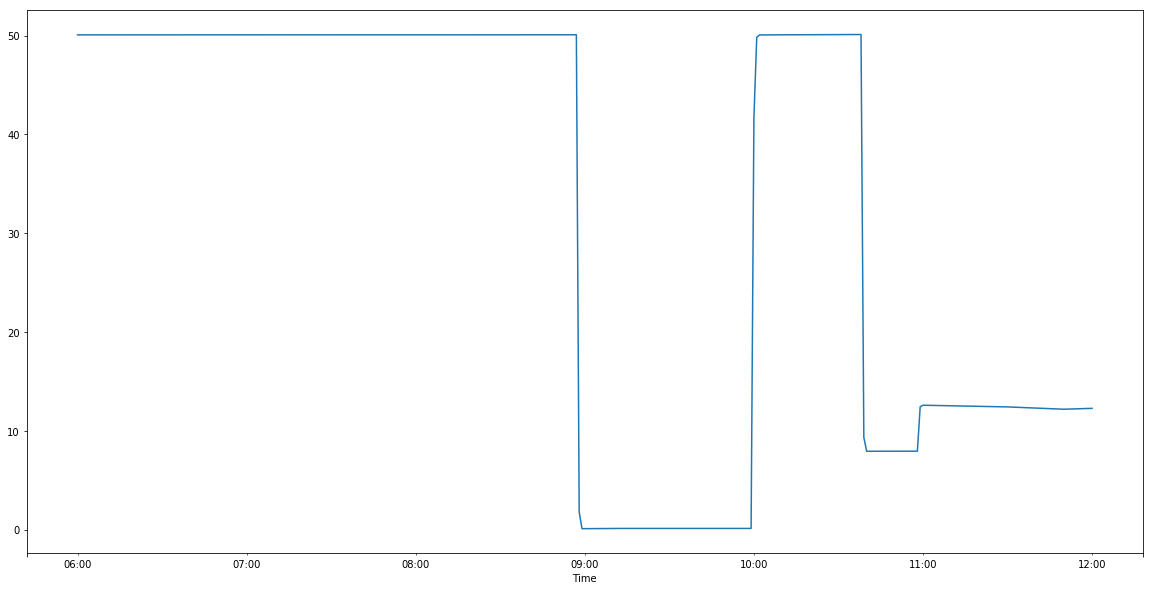

In [19]:
S_for_interpolate.interpolate(method = 'pad', inplace = True)
S_for_interpolate.plot(figsize = (20, 10))

Изначально думал интерполировать ряд линейным методом, однако случай, проиллюстрированный выше, показал мне, что лучше ряд интерполировать предыдущими значениями, так как они в некоторых ситуациях имеют больше смысла, чем линейная интерполяция. Поэтому в pd.interpolate для рядов в качестве метода я выбрал pad. Учитывая то, что ряд имеет свыше 300 тысяч значений, то это по факту не играет большой роли. После того, как я отрезал часть ряда с плохими данными, пропущенных значений осталось сравнительно немного.

In [20]:
S.interpolate(method = 'pad', inplace = True)
T.interpolate(method = 'pad', inplace = True)

А теперь - тест Дики-Фуллера

In [21]:
adfs = adfuller(S.resample('H', how = 'mean'))
print('adf: ', adfs[0])
print('p-value: ', adfs[1])
print('critical values: ', adfs[4])

adf:  -4.964637255943479
p-value:  2.6061760761529087e-05
critical values:  {'1%': -3.4315855945219402, '5%': -2.862086005864098, '10%': -2.5670606384325727}


In [22]:
adft = adfuller(T.resample('H', how = 'mean'))
print('adf: ', adft[0])
print('p-value: ', adft[1])
print('critical values: ', adft[4])

adf:  -3.3080125791826083
p-value:  0.014524089080539522
critical values:  {'1%': -3.4315804795661453, '5%': -2.8620837460466486, '10%': -2.567059435453345}


Делаем выводы - оба ряда по тесту Дики-Фуллера являются стационарными на уровне значимости 5%, единичных корней нет

Оценим основные статистики по обоим рядам

In [23]:
S.describe()

count    319681.000000
mean         10.613921
std           3.989754
min           0.088219
25%           9.352942
50%          10.769720
75%          12.318345
max          50.105118
Name: S, dtype: float64

In [24]:
T.describe()

count    319681.000000
mean        250.907730
std          33.927402
min         118.807358
25%         242.725082
50%         255.250916
75%         264.504883
max         361.981293
Name: T, dtype: float64

Рассчитаем dS и dT с теми параметрами, которые указаны в задании 1

In [25]:
dS = S[S.index >= '2017-05-24 01:00:00'].diff(60)
dT = T.tshift(60).diff(60)

In [26]:
print(dS.shape, dT.shape)

(319621,) (319681,)


In [27]:
def masked_array(df):
    mask = (df.index >= '2017-05-24 02:00:00') & (df.index <= '2018-01-01 00:00:00')
    df_masked = df[mask]
    return df_masked

In [28]:
dS = masked_array(dS)
dT = masked_array(dT)

<Figure size 1440x1440 with 0 Axes>

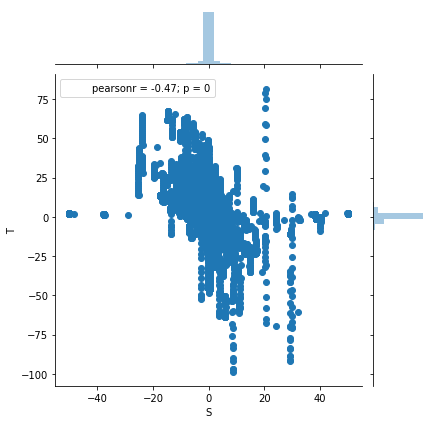

In [29]:
plt.figure(figsize = (20, 20))
sns.jointplot(dS, dT)

Зависимость производных в целом похожа при данных ta, tb и tm на обратно пропорциональную. Посчитаем теперь k во времени.

In [30]:
k = dS/dT

Зависимость k во времени - на графике ниже

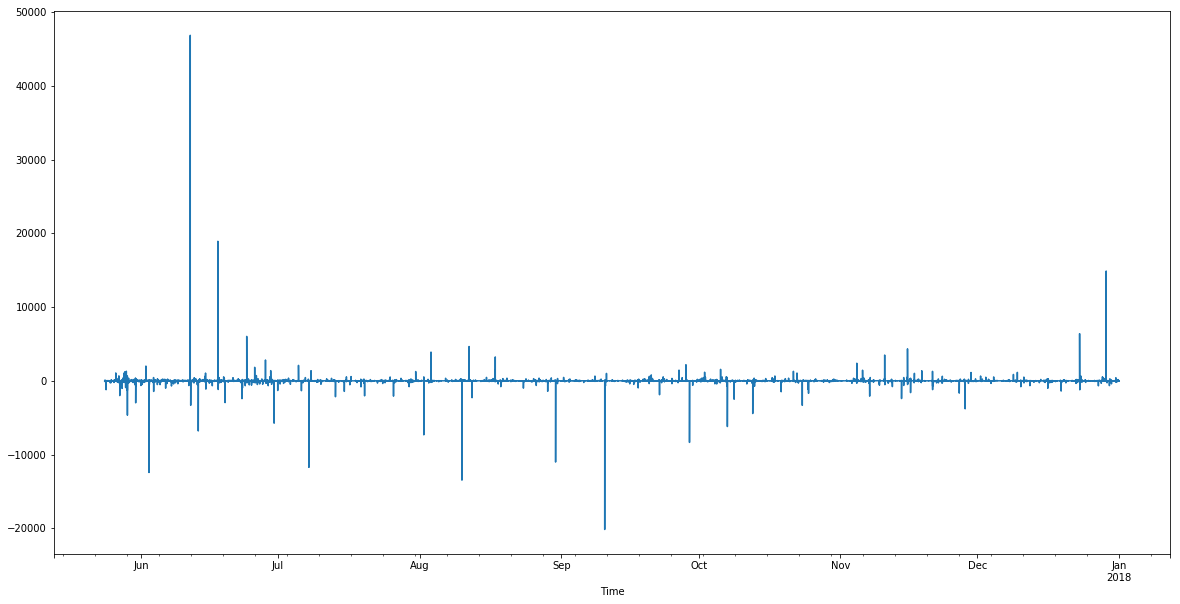

In [31]:
k.plot(figsize = (20, 10))

Основные статистики по исходному ряду k - ниже

In [32]:
k.replace([-np.inf, np.inf], np.nan, inplace=True)
k.describe()

count    319557.000000
mean         -0.316672
std         118.451630
min      -20157.656250
25%          -0.533227
50%          -0.214152
75%           0.103671
max       46841.125000
dtype: float64

Посмотрим на распределение значений k, есть гипотеза, что оно похоже на нормальное, исходя из графика dS/dT. Функцией trimboth почистим ряд от выбросов для более наглядной визуализации.

In [33]:
from scipy.stats import trimboth

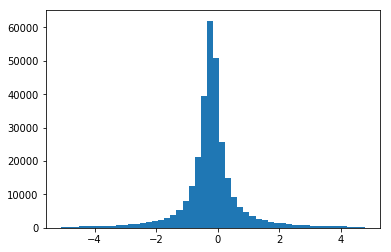

In [34]:
plt.hist(trimboth(k.dropna(), 0.025), bins = 50);
plt.show()

И правда, похоже на нормальное, но с более тяжелыми хвостами. Но для распределения Лапласа хвосты слишком "легкие".

Возможно, распределение k соответствует распределению Коши, которое можно получить с помощью метода выборки с отклонением из равномерного распределения. В любом случае, мы можем оценить математическое ожидание распределения Коши с помощью медианы ряда (для нормального она тоже подходит).

In [35]:
print('Математическое ожидание ряда k: ', np.median(k.dropna()))

Математическое ожидание ряда k:  -0.21415165


In [36]:
print('Дисперсия ряда k: ', np.var(k.dropna()))

Дисперсия ряда k:  14030.7451171875


### Исследуем tl, для которого мат. ожидание k будет максимальным

In [37]:
def k_compute(S, T, tl = 60):
    dS = S[S.index >= '2017-05-24 01:00:00'].diff(tl)
    dT = T.tshift(60).diff(tl)
    k = dS/dT
    k.replace([-np.inf, np.inf], np.nan, inplace=True)
    return k.dropna()

In [38]:
k_max = -1000
tl_max = 0
for i in range(1, 300):
    k_pretend = k_compute(S, T, tl = i)
    k_median = np.median(k_pretend)
    if k_median > k_max:
        k_max = k_median
        tl_max = i
        
print('Мат. ожидание: ', k_max)
print('tl max: ', tl_max)

Мат. ожидание:  -0.08685601
tl max:  1


Посмотрим на основные статистики ряда k при tl = 1

In [39]:
k_max = k_compute(S, T, tl = tl_max)
k_max.describe()

count    316837.000000
mean         -0.152784
std          12.155006
min       -3088.689697
25%          -0.427834
50%          -0.086856
75%           0.194520
max        2073.816162
dtype: float64

### Построим авторегрессионную модель

Для начала выделим некоторую часть выборки, на которой будем строить модель и прогноз. Снизим дискретность до почасовых наблюдений, чтобы колебания ряда были меньше

In [40]:
forecast_train = S[(S.index >= '2017-08-03 00:00:00') & (S.index < '2017-08-12 00:00:00')].resample('H', how = 'mean')
forecast_test = S[(S.index >= '2017-08-12 00:00:00') & (S.index <= '2017-08-13 00:00:00')].resample('H', how = 'mean')

In [41]:
train = forecast_train.diff(1).dropna()
test = forecast_test.diff(1).dropna()

In [42]:
adff = adfuller(forecast_train)
print('adf: ', adff[0])
print('p-value: ', adff[1])
print('critical values: ', adff[4])

adf:  -5.414072995951469
p-value:  3.1641366027120353e-06
critical values:  {'1%': -3.462818103072159, '5%': -2.8758145932936805, '10%': -2.574378674548251}


Ряд стационарен, соответственно компонента d при прогнозировании моделью ARIMA равна нулю, по факту, это модель ARMA.

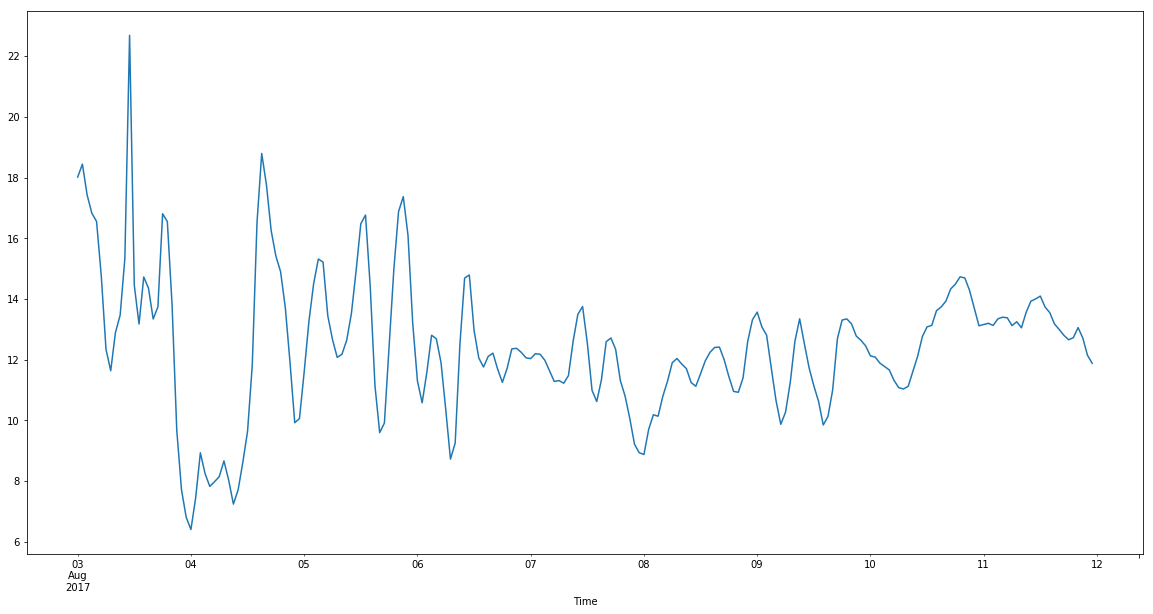

In [43]:
forecast_train.plot(figsize = (20, 10))

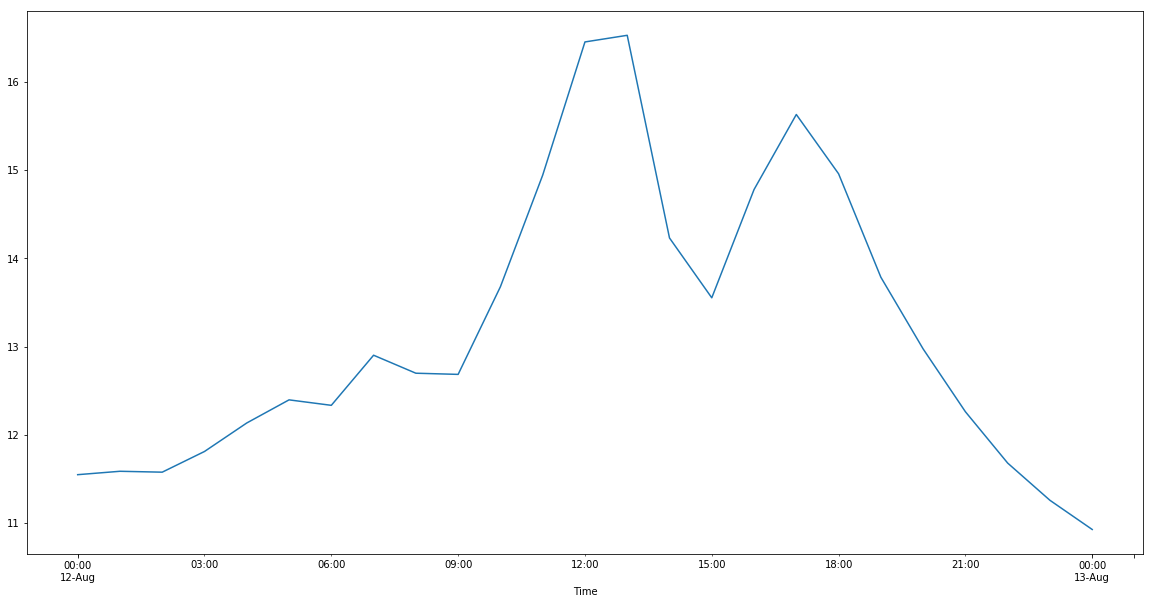

In [44]:
forecast_test.plot(figsize = (20, 10))

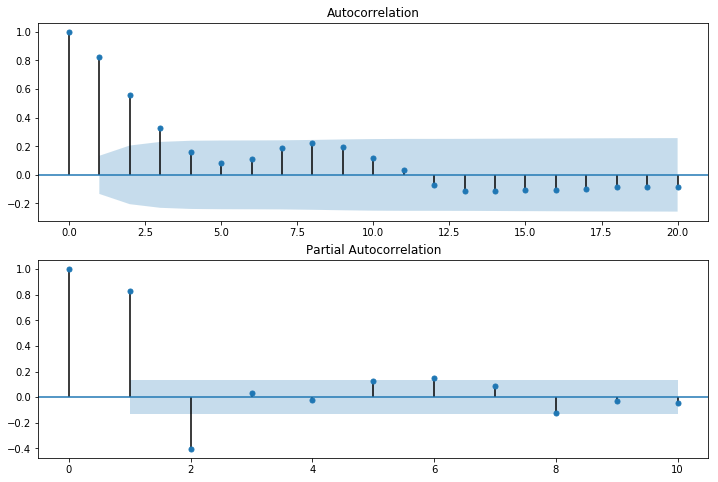

In [45]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(forecast_train, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(forecast_train, lags=10, ax=ax2)

По ACF и PACF определяем компоненты p и q для модели ARMA. По графикам видно, что лучше брать p=1 и q=1

In [46]:
import statsmodels
model = statsmodels.tsa.arima_model.ARIMA(forecast_train, order = (1,0,1))
model_fit = model.fit()

In [47]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      S   No. Observations:                  216
Model:                     ARMA(1, 1)   Log Likelihood                -339.016
Method:                       css-mle   S.D. of innovations              1.158
Date:                Wed, 05 Jun 2019   AIC                            686.031
Time:                        08:32:32   BIC                            699.533
Sample:                    08-03-2017   HQIC                           691.486
                         - 08-11-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5072      0.426     29.338      0.000      11.672      13.343
ar.L1.S        0.7381      0.052     14.243      0.000       0.637       0.840
ma.L1.S        0.4361      0.065      6.677      0.000       0.308       0.564
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3549           +0.0000j            1.3549            0.0000
MA.1           -2.2928           +0.0000j            2.2928            0.5000
-----------------------------------------------------------------------------
"""

In [48]:
res = pd.DataFrame(model_fit.resid)

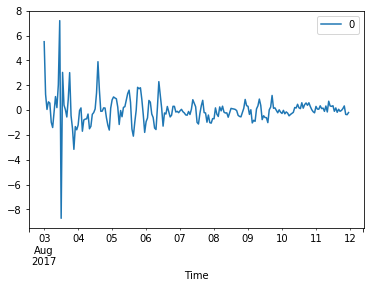

In [49]:
res.plot()

График остатков выглядит как белый шум, следовательно, модель вобрала в себя информацию о тренде

Визуализируем предсказания модели

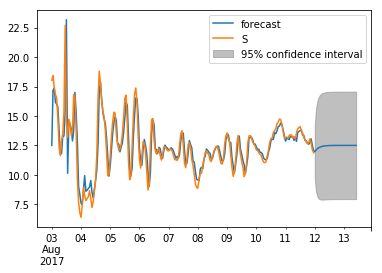

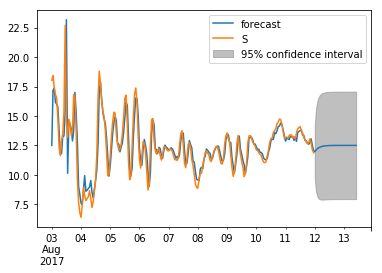

In [50]:
model_fit.plot_predict(end = '2017-08-13 10:00:00')

In [51]:
predicted_test = pd.DataFrame(model_fit.forecast(steps = 25)[0], index = forecast_test.index)

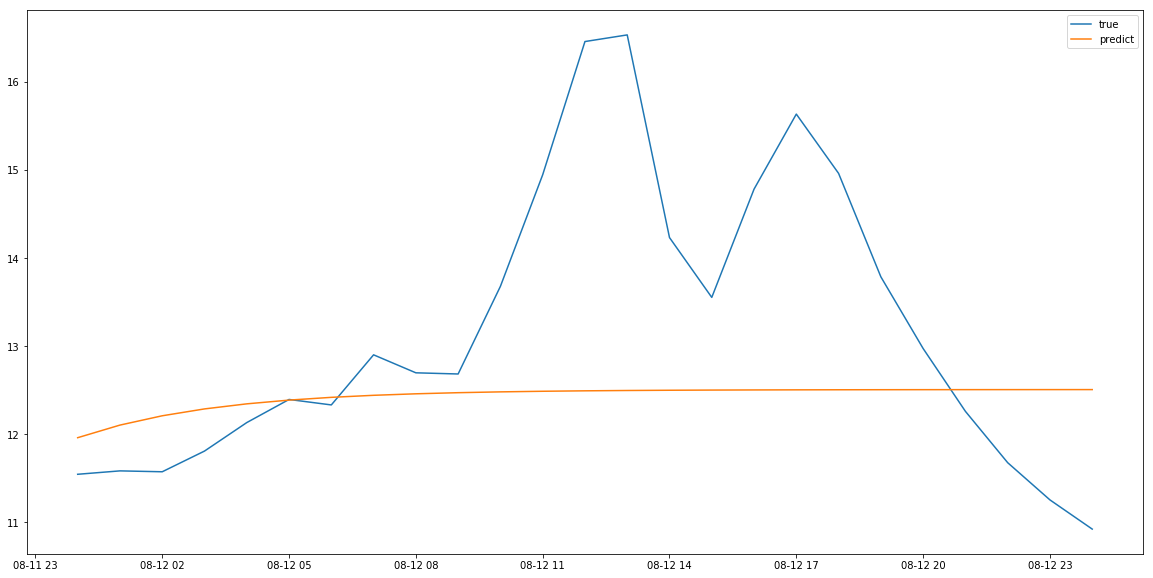

In [52]:
fig = plt.figure(figsize = (20, 10))
plt.plot(forecast_test, label = 'true')
plt.plot(predicted_test, label = 'predict')
plt.legend()

Видим, что колебания ряда модель предсказать не может, однако в 95% доверительный интервал фактические значения ряда укладываются. Теперь оценим модель.

In [53]:
from sklearn import metrics

In [54]:
print('MAE: ', metrics.mean_absolute_error(forecast_test, predicted_test))
print('MSE: ', metrics.mean_squared_error(forecast_test, predicted_test))
print('R2 score: ', metrics.r2_score(forecast_test, predicted_test))

MAE:  1.2492515753740063
MSE:  2.909727414008905
R2 score:  -0.14850681243791364


Средние ошибки получились относительно небольшими, однако на тестовой выборке коэффициент детерминации низкий. Такую модель для прогнозирования лучше не использовать.

In [460]:
print('Коэффициент корреляции k с T: ', k.corr(T))

Коэффициент корреляции k с T:  -0.0018791558008082899


### Задание №2

Напишем функцию, вычисляющую k с заданными ta, tb и tm

In [56]:
def k_compute_with_tm_ta_tb(S, T, date_start, ta = 60, tm = 60, tb = 60, mode = 'single'):
    assert mode in ['single', 'multi']
    hour = tm//60
    minute = tm%60
    date_start_S = date_start + pd.Timedelta(hour, unit = 'h') + pd.Timedelta(minute, unit = 'm')
    if mode == 'single':
        date_end = S.index[-1]
    if mode == 'multi':
        date_end = date_start + pd.Timedelta(1, unit = 'D')
    dS = S[(S.index >= date_start_S) & (S.index < date_end)].diff(ta)
    dT = T[(T.index >= date_start) & (T.index < date_end)].tshift(tm).diff(tb)
    k = dS/dT
    k.replace([-np.inf, np.inf], np.nan, inplace=True)
    return k.dropna(), date_end

In [58]:
def tm_optimal(S, T, date_start):
    df = pd.DataFrame(columns = ['k', 'tm'])
    date = date_start
    while date < pd.Timestamp(year = 2018, month = 1, day = 1, hour = 0, minute = 0):
        k_max = -1000
        tm_max = 0
        for i in range(1, 421):
            k_pretend, date_end = k_compute_with_tm_ta_tb(S, T, date, tm = i, mode = 'multi')
            k_median = np.median(k_pretend) 
            if k_median > k_max:
                k_max = k_median
                tm_max = i
        df.loc[date] = [k_max, tm_max]
        #print('Done at: ', date)
        date = date_end
    return df

In [59]:
date_start = pd.Timestamp(year = 2017, month = 5, day = 24, hour = 0, minute = 0)

In [60]:
df = tm_optimal(S, T, date_start)

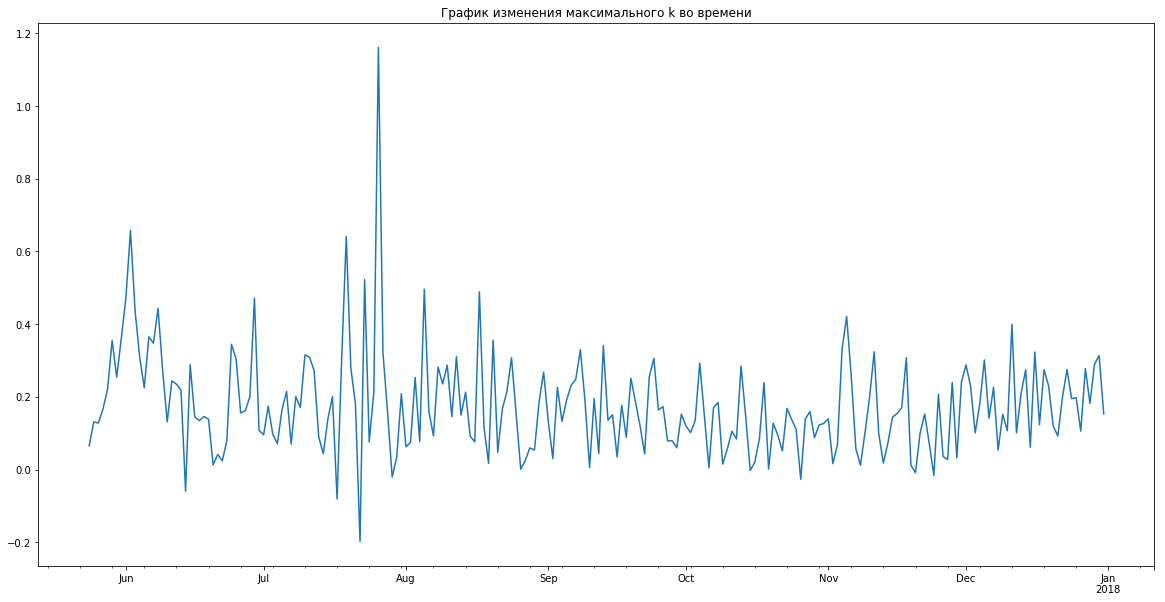

In [61]:
plt.title('График изменения максимального k во времени')
df['k'].plot(figsize = (20, 10))

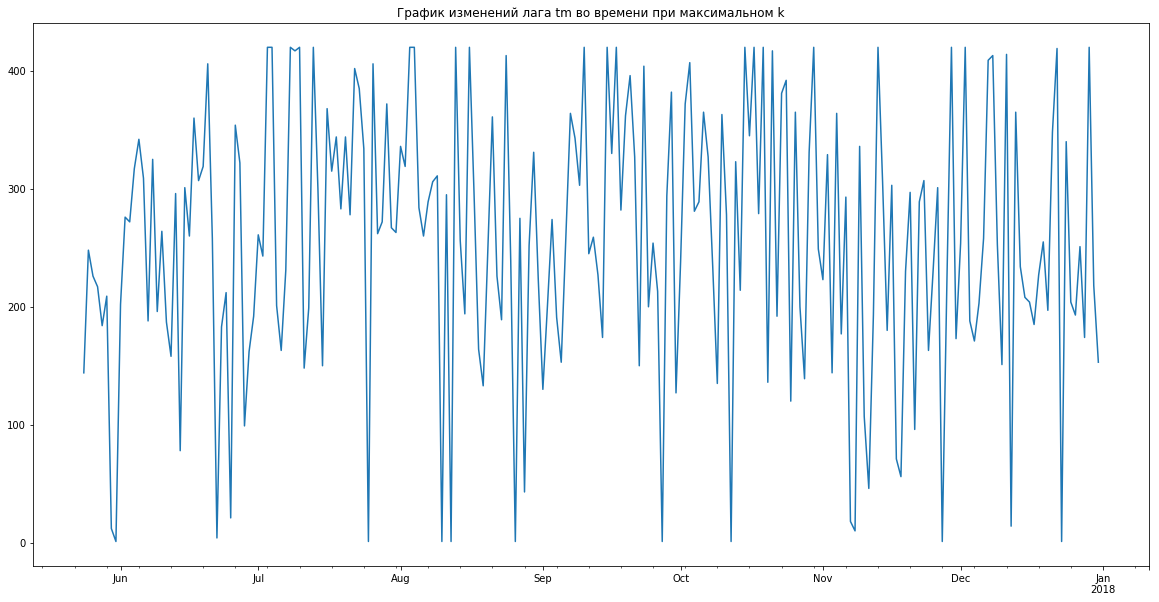

In [62]:
plt.title('График изменений лага tm во времени при максимальном k')
df['tm'].plot(figsize = (20, 10))

### Задание №3

In [63]:
S.index[0]

Timestamp('2017-05-24 00:00:00')

In [64]:
def ta_tb_optimal(S, T):
    k_max = -1000
    ta_max = 0
    tb_max = 0
    for ta in range(30, 91):
        for tb in range(30, 91):
            k_pretend, date_end = k_compute_with_tm_ta_tb(S, T, S.index[0], ta = ta, tb = tb, mode = 'single')
            k_median = np.median(k_pretend)
            if k_median > k_max:
                k_max = k_median
                ta_max = ta
                tb_max = tb
        #print('current k_max: ', k_max)
        #print('current ta_max: ', ta_max)
        #print('current tb_max: ', tb_max)
    return ta_max, tb_max

In [65]:
ta_max, tb_max = ta_tb_optimal(S, T)

Альтернативная "жадная" реализация (не уверен в ее правильности, но думал и в эту сторону тоже)

In [66]:
def tatb_optimize_greedy(S, T):
    k_max = -1000
    ta_max = 0
    tb_max = 0
    ta_df = pd.DataFrame(columns=['k'])
    tb_df = pd.DataFrame(columns=['k'])
    for ta in range(30, 91):
        k_pretend, date_end = k_compute_with_tm_ta_tb(S, T, S.index[0], ta = ta, mode = 'single')
        k_median = np.median(k_pretend)
        ta_df.loc[ta] = k_median
        if k_median > k_max:
            k_max = k_median
            ta_max = ta
    
    for tb in range(30, 91):
        k_pretend, date_end = k_compute_with_tm_ta_tb(S, T, S.index[0], ta = ta_max, tb = tb, mode = 'single')
        k_median = np.median(k_pretend)
        tb_df.loc[tb] = k_median
        if k_median > k_max:
            k_max = k_median
            tb_max = tb
    
    return ta_max, tb_max, ta_df, tb_df

In [67]:
ta_max_greedy, tb_max_greedy, ta_df, tb_df = tatb_optimize_greedy(S, T)

In [68]:
print(ta_max_greedy, tb_max_greedy)

30 90


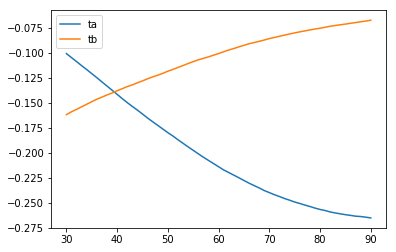

In [462]:
plt.plot(ta_df['k'], label = 'ta')
plt.plot(tb_df['k'], label = 'tb')
plt.legend()

У меня не вышло доказать, что k максимально при ta = tb, однако выше я привел свои попытки исследовать этот вопрос.

### Задание 4

In [70]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"; 
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [71]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [72]:
cointegration_test = statsmodels.tsa.stattools.coint(S, T)

In [73]:
print('t-statistic: ', cointegration_test[0])
print('p-value: ', cointegration_test[1])
print('critical values:', cointegration_test[2])

t-statistic:  -21.108003077031142
p-value:  0.0
critical values: [-3.89647426 -3.33614911 -3.04446327]


Ряды действительно являются коинтегрированными (зависящими друг от друга)

Попробуем предсказать значения ряда S на 60 минут вперед, используя LSTM-сеть, но для начала нужно преобразовать данные, чтобы их можно было подать на вход в модель, для начала отрежем ряд, оставив только последний месяц.

In [347]:
S_task4 = S[S.index >= '2017-12-01 00:00:00']

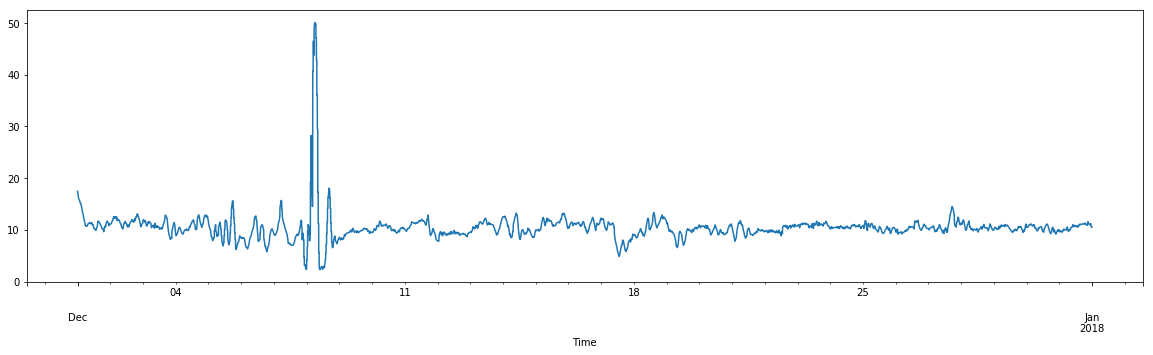

In [348]:
S_task4.plot(figsize = (20, 5))

Для использования нейронной сети необходимо выполнить scaling данных. Так как нам потом преобразовывать все обратно, то использую MinMaxScaler при всех его минусах (чувствительности к выбросам в частности).

In [387]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(S_task4.values.reshape(-1, 1))
scaled_series = pd.DataFrame(scaled, index = S_task4.index, columns = ['s'])

Создаем DataFrame, состоящий из предыдущих значений ряда

In [390]:
window_size = 60

s_copy = scaled_series.copy()
for i in range(window_size):
    scaled_series = pd.concat([scaled_series, s_copy.shift(i+1)], axis = 1)

In [391]:
scaled_series.dropna(inplace=True)

In [393]:
model = Sequential()
model.add(LSTM(activation = 'relu', input_shape = (1, 60), output_dim = 60))
model.add(Dense(1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 61        
Total params: 29,101
Trainable params: 29,101
Non-trainable params: 0
_________________________________________________________________


In [394]:
train_size = int(len(scaled_series) * 0.8)
test_size = len(scaled_series) - train_size
train, test = scaled_series.iloc[0:train_size,:], scaled_series.iloc[train_size:len(scaled_series),:]
print(len(train), len(test))

35664 8917


In [395]:
trainY = train.iloc[:, 0]
trainX = train.iloc[:, 1:61].values
testY = test.iloc[:, 0]
testX = test.iloc[:, 1:61].values

LSTM слой требует на вход данные в 3-dimesional виде, преобразуем

In [396]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [397]:
history = model.fit(trainX, trainY, batch_size = 16, epochs = 3, validation_data=(testX, testY), shuffle = False)

Train on 35664 samples, validate on 8917 samples
Epoch 1/3
35664/35664 [==============================] - 16s 447us/step - loss: 5.9928e-04 - mean_absolute_error: 0.0112 - val_loss: 3.6804e-05 - val_mean_absolute_error: 0.0039
Epoch 2/3
35664/35664 [==============================] - 12s 339us/step - loss: 3.6504e-04 - mean_absolute_error: 0.0062 - val_loss: 1.4026e-05 - val_mean_absolute_error: 0.0026
Epoch 3/3
35664/35664 [==============================] - 12s 342us/step - loss: 3.0943e-04 - mean_absolute_error: 0.0063 - val_loss: 2.8207e-05 - val_mean_absolute_error: 0.0035


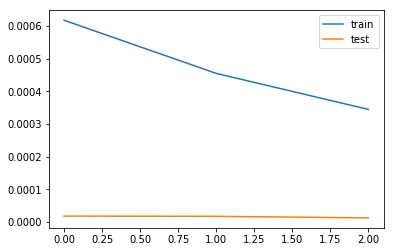

In [376]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

3 эпох обучения достаточно, судя по моим экспериментам с разными архитектурами

In [377]:
yhat = model.predict(testX)

In [378]:
metrics.mean_absolute_error(testY, yhat)

0.0025767786

In [379]:
y_pred = scaler.inverse_transform(yhat)

In [380]:
y_test = S_task4.iloc[train_size:len(scaled_series)]

In [381]:
y_pred = pd.DataFrame(y_pred, index=y_test.index)

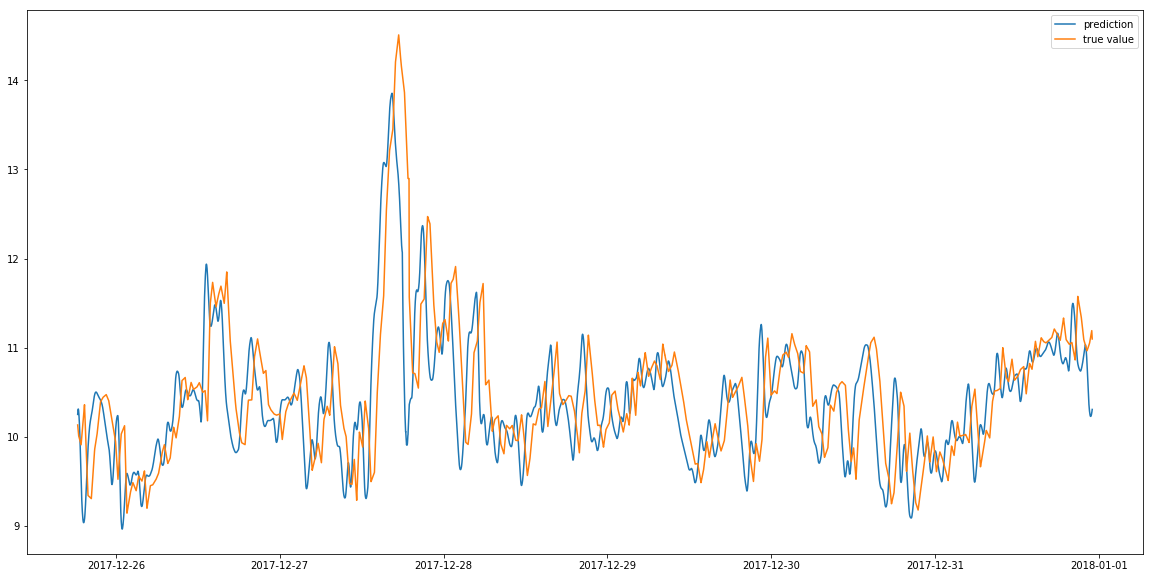

In [382]:
plt.figure(figsize = (20, 10))
plt.plot(y_pred, label = 'prediction')
plt.plot(y_test, label = 'true value')
plt.legend()

In [383]:
print('MAE: ', metrics.mean_absolute_error(y_pred, y_test))
print('MSE: ', metrics.mean_squared_error(y_pred, y_test))
print('R2 score: ', metrics.r2_score(y_pred, y_test))

MAE:  0.43673012
MSE:  0.3676358
R2 score:  0.23680256078328143


Получилась вроде не самая плохая модель по оценке на тестовой выборке (разве что R2 меня немного смущает). Давайте попробуем спрогнозировать ряд на 60 минут вперед

In [451]:
last_hour = S_task4[S_task4.index > '2017-12-31 23:00:00']

In [454]:
for_pred = pd.DataFrame(last_hour.values[::-1]).T
for_pred.index = [pd.Timestamp(year = 2018, month = 1, day = 1, hour = 0, minute = 1)]
scaled_X = scaler.transform(for_pred)
predicted_value = model.predict(scaled_X.reshape(1, 1, 60))
predicted_value = scaler.inverse_transform(predicted_value)

In [455]:
for_pred['prediction'] = predicted_value

In [456]:
date_start = for_pred.index[0]
for_pred_copy = for_pred.copy()
for row in range(1, 60):
    for_pred_copy.loc[date_start + pd.Timedelta(row, unit = 'm')] = np.nan
    for col in range(for_pred.shape[1] - 1):
        for_pred_copy.iloc[row, col] = for_pred_copy.iloc[row - 1, col + 1]
    scaled_X = scaler.transform(for_pred_copy.iloc[row, 0:60].values.reshape(60, 1).T)
    for_pred_copy.iloc[row, -1] = scaler.inverse_transform(model.predict(scaled_X.reshape(1,1,60)))

In [457]:
prediction = for_pred_copy['prediction']

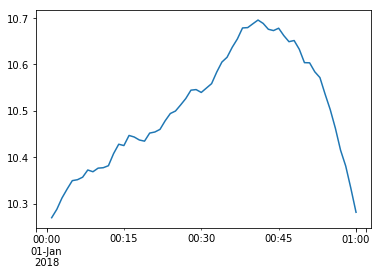

In [458]:
prediction.plot()